<a href="https://colab.research.google.com/github/SIDIBEMoussa/Image-segmentation-using-U-Net_/blob/main/Unet_fron_scratch_with_DRIVE_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup data directory

In [3]:
! rm -r /content/DRIVE

In [4]:
from zipfile import ZipFile
from google.colab import drive
from pathlib import Path
import os

if os.path.exists("/content/DRIVE")==False or os.path.exists("/content/utils.py") == False:

    drive.mount('/content/drive/')

    file_dir_in_drive = "/content/drive/MyDrive/Tokenkagle/archive.zip"

    ! cp /content/drive/MyDrive/Tokenkagle/utils.py /content/utils.py

    # loading the temp.zip and creating a zip object
    with ZipFile(file_dir_in_drive, 'r') as zObject:

        # Extracting all the members of the zip
        # into a specific location.
        zObject.extractall(
            path="/content/")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [5]:
!import os
import numpy as np
import cv2
import torch
from torch.utils.data import Dataset
import time
from glob import glob

from torch.utils.data import DataLoader
import torch.nn as nn

from operator import add
from tqdm import tqdm
import imageio
from sklearn.metrics import accuracy_score, f1_score, jaccard_score, precision_score, recall_score

from utils import create_dir, seeding, epoch_time
from albumentations import HorizontalFlip, VerticalFlip, Rotate

/bin/bash: import: command not found


In [6]:
""" Create a directory """
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

def load_data(path):
    train_x = sorted(glob(os.path.join(path, "training", "images", "*.tif")))
    train_y = sorted(glob(os.path.join(path, "training", "1st_manual", "*.gif")))

    test_x = sorted(glob(os.path.join(path, "test", "images", "*.tif")))
    test_y = sorted(glob(os.path.join(path, "test", "1st_manual", "*.gif")))

    return (train_x, train_y), (test_x, test_y)

def augment_data(images, masks, save_path, augment=True):
    size = (512, 512)

    for idx, (x, y) in tqdm(enumerate(zip(images, masks)), total=len(images)):
        """ Extracting the name """
        name = x.split("/")[-1].split(".")[0]

        """ Reading image and mask """
        x = cv2.imread(x, cv2.IMREAD_COLOR)
        y = imageio.mimread(y)[0]

        if augment == True:
            aug = HorizontalFlip(p=1.0)
            augmented = aug(image=x, mask=y)
            x1 = augmented["image"]
            y1 = augmented["mask"]

            aug = VerticalFlip(p=1.0)
            augmented = aug(image=x, mask=y)
            x2 = augmented["image"]
            y2 = augmented["mask"]

            aug = Rotate(limit=45, p=1.0)
            augmented = aug(image=x, mask=y)
            x3 = augmented["image"]
            y3 = augmented["mask"]

            X = [x, x1, x2, x3]
            Y = [y, y1, y2, y3]

        else:
            X = [x]
            Y = [y]

        index = 0
        for i, m in zip(X, Y):
            i = cv2.resize(i, size)
            m = cv2.resize(m, size)

            tmp_image_name = f"{name}_{index}.png"
            tmp_mask_name = f"{name}_{index}.png"

            image_path = os.path.join(save_path, "image", tmp_image_name)
            mask_path = os.path.join(save_path, "mask", tmp_mask_name)

            cv2.imwrite(image_path, i)
            cv2.imwrite(mask_path, m)

            index += 1

if __name__ == "__main__":
    """ Seeding """
    np.random.seed(42)

    """ Load the data """
    #data_path = "/media/nikhil/ML/ml_dataset/Retina blood vessel segmentation/"
    data_path = "/content/DRIVE"
    (train_x, train_y), (test_x, test_y) = load_data(data_path)

    print(f"Train: {len(train_x)} - {len(train_y)}")
    print(f"Test: {len(test_x)} - {len(test_y)}")

    """ Create directories to save the augmented data """
    create_dir("new_data/train/image/")
    create_dir("new_data/train/mask/")
    create_dir("new_data/test/image/")
    create_dir("new_data/test/mask/")

    """ Data augmentation """
    augment_data(train_x, train_y, "new_data/train/", augment=True)
    augment_data(test_x, test_y, "new_data/test/", augment=False)


Train: 20 - 20
Test: 20 - 20


100%|██████████| 20/20 [00:00<00:00, 32.28it/s]


# Loss functions

In [7]:

import torch
import torch.nn as nn
import torch.nn.functional as F

class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = torch.sigmoid(inputs)

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)

        return 1 - dice

class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = torch.sigmoid(inputs)

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss

        return Dice_BCE

# Model

In [8]:
class conv_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_c)

        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_c)

        self.relu = nn.ReLU()

    def forward(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        return x

class encoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.conv = conv_block(in_c, out_c)
        self.pool = nn.MaxPool2d((2, 2))

    def forward(self, inputs):
        x = self.conv(inputs)
        p = self.pool(x)

        return x, p

class decoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.up = nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2, padding=0)
        self.conv = conv_block(out_c+out_c, out_c)

    def forward(self, inputs, skip):
        x = self.up(inputs)
        x = torch.cat([x, skip], axis=1)
        x = self.conv(x)
        return x

class build_unet(nn.Module):
    def __init__(self):
        super().__init__()

        """ Encoder """
        self.e1 = encoder_block(3, 64)
        self.e2 = encoder_block(64, 128)
        self.e3 = encoder_block(128, 256)
        self.e4 = encoder_block(256, 512)

        """ Bottleneck """
        self.b = conv_block(512, 1024)

        """ Decoder """
        self.d1 = decoder_block(1024, 512)
        self.d2 = decoder_block(512, 256)
        self.d3 = decoder_block(256, 128)
        self.d4 = decoder_block(128, 64)

        """ Classifier """
        self.outputs = nn.Conv2d(64, 1, kernel_size=1, padding=0)

    def forward(self, inputs):
        """ Encoder """
        s1, p1 = self.e1(inputs)
        s2, p2 = self.e2(p1)
        s3, p3 = self.e3(p2)
        s4, p4 = self.e4(p3)

        """ Bottleneck """
        b = self.b(p4)

        """ Decoder """
        d1 = self.d1(b, s4)
        d2 = self.d2(d1, s3)
        d3 = self.d3(d2, s2)
        d4 = self.d4(d3, s1)

        outputs = self.outputs(d4)

        return outputs

if __name__ == "__main__":
    x = torch.randn((2, 3, 512, 512))
    f = build_unet()
    y = f(x)
    print(y.shape)

torch.Size([2, 1, 512, 512])




# Data directory

In [9]:
path_to_train_image = "/content/DRIVE/training/images/*"
path_to_train_mask = "/content/DRIVE/training/1st_manual/*"

path_to_test_image = "/content/DRIVE/test/images/*"
path_to_test_mask = "/content/DRIVE/test/mask/*"

In [10]:
 #from google.colab.patches import cv2_imshow

#path = sorted(glob(path_to_train_mask))[0]

#cap = cv2.VideoCapture(path)
#ret, image = cap.read()
#cap.release()

#image #= cv2_imshow(image)

# Data

In [11]:

import os
import numpy as np
import cv2
import torch
from torch.utils.data import Dataset

class DriveDataset(Dataset):
    def __init__(self, images_path, masks_path):

        self.images_path = images_path
        self.masks_path = masks_path
        self.n_samples = len(images_path)

    def __getitem__(self, index):
        """ Reading image """
        image = cv2.imread(self.images_path[index], cv2.IMREAD_COLOR)
        image = image/255.0 ## (512, 512, 3)
        image = np.transpose(image, (2, 0, 1))  ## (3, 512, 512)
        image = image.astype(np.float32)
        image = torch.from_numpy(image)

        """ Reading mask """
        mask = cv2.imread(self.masks_path[index], cv2.IMREAD_GRAYSCALE)
        mask = mask/255.0   ## (512, 512)
        mask = np.expand_dims(mask, axis=0) ## (1, 512, 512)
        mask = mask.astype(np.float32)
        mask = torch.from_numpy(mask)

        return image, mask

    def __len__(self):
        return self.n_samples

# Training

In [12]:
def train(model, loader, optimizer, loss_fn, device):
    epoch_loss = 0.0

    model.train()
    for x, y in loader:
        x = x.to(device, dtype=torch.float32)
        y = y.to(device, dtype=torch.float32)

        optimizer.zero_grad()
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    epoch_loss = epoch_loss/len(loader)
    return epoch_loss

def evaluate(model, loader, loss_fn, device):
    epoch_loss = 0.0

    model.eval()
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device, dtype=torch.float32)
            y = y.to(device, dtype=torch.float32)

            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            epoch_loss += loss.item()

        epoch_loss = epoch_loss/len(loader)
    return epoch_loss

if __name__ == "__main__":
    """ Seeding """
    seeding(42)

    """ Directories """
    create_dir("files")

    """ Load dataset """
    train_x = sorted(glob("/content/new_data/train/image/*"))
    train_y = sorted(glob("/content/new_data/train/mask/*"))

    valid_x = sorted(glob("/content/new_data/test/image/*"))
    valid_y = sorted(glob("/content/new_data/test/mask/*"))

    data_str = f"Dataset Size:\nTrain: {len(train_x)} - Valid: {len(valid_x)}\n"
    print(data_str)

    """ Hyperparameters """
    H = 512
    W = 512
    size = (H, W)
    batch_size = 2
    num_epochs = 50
    lr = 1e-4
    checkpoint_path = "files/checkpoint.pth"

    """ Dataset and loader """
    train_dataset = DriveDataset(train_x, train_y)
    valid_dataset = DriveDataset(valid_x, valid_y)

    train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2
    )

    valid_loader = DataLoader(
        dataset=valid_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2
    )

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')   ## Choose of processor unit
    model = build_unet()
    model = model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, verbose=True)
    loss_fn = DiceBCELoss()

    """ Training the model """
    best_valid_loss = float("inf")

    for epoch in range(num_epochs):
        start_time = time.time()

        train_loss = train(model, train_loader, optimizer, loss_fn, device)
        valid_loss = evaluate(model, valid_loader, loss_fn, device)

        """ Saving the model """
        if valid_loss < best_valid_loss:
            data_str = f"Valid loss improved from {best_valid_loss:2.4f} to {valid_loss:2.4f}. Saving checkpoint: {checkpoint_path}"
            print(data_str)

            best_valid_loss = valid_loss
            torch.save(model.state_dict(), checkpoint_path)

        end_time = time.time()
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        data_str = f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s\n'
        data_str += f'\tTrain Loss: {train_loss:.3f}\n'
        data_str += f'\t Val. Loss: {valid_loss:.3f}\n'
        print(data_str)

Dataset Size:
Train: 80 - Valid: 20

Valid loss improved from inf to 1.3432. Saving checkpoint: files/checkpoint.pth
Epoch: 01 | Epoch Time: 0m 29s
	Train Loss: 1.167
	 Val. Loss: 1.343

Valid loss improved from 1.3432 to 0.9801. Saving checkpoint: files/checkpoint.pth
Epoch: 02 | Epoch Time: 0m 29s
	Train Loss: 0.983
	 Val. Loss: 0.980

Valid loss improved from 0.9801 to 0.8912. Saving checkpoint: files/checkpoint.pth
Epoch: 03 | Epoch Time: 0m 30s
	Train Loss: 0.922
	 Val. Loss: 0.891

Valid loss improved from 0.8912 to 0.8522. Saving checkpoint: files/checkpoint.pth
Epoch: 04 | Epoch Time: 0m 31s
	Train Loss: 0.876
	 Val. Loss: 0.852

Valid loss improved from 0.8522 to 0.8164. Saving checkpoint: files/checkpoint.pth
Epoch: 05 | Epoch Time: 0m 31s
	Train Loss: 0.836
	 Val. Loss: 0.816

Valid loss improved from 0.8164 to 0.7713. Saving checkpoint: files/checkpoint.pth
Epoch: 06 | Epoch Time: 0m 31s
	Train Loss: 0.798
	 Val. Loss: 0.771

Valid loss improved from 0.7713 to 0.7423. Savin

# Testing

In [66]:
def calculate_metrics(y_true, y_pred):
    """ Ground truth """
    y_true = y_true.cpu().numpy()
    y_true = y_true > 0.5
    y_true = y_true.astype(np.uint8)
    y_true = y_true.reshape(-1)

    """ Prediction """
    y_pred = y_pred.cpu().numpy()
    y_pred = y_pred > 0.5
    y_pred = y_pred.astype(np.uint8)
    y_pred = y_pred.reshape(-1)

    score_jaccard = jaccard_score(y_true, y_pred)
    score_f1 = f1_score(y_true, y_pred)
    score_recall = recall_score(y_true, y_pred)
    score_precision = precision_score(y_true, y_pred)
    score_acc = accuracy_score(y_true, y_pred)

    return [score_jaccard, score_f1, score_recall, score_precision, score_acc]

def mask_parse(mask):
    mask = np.expand_dims(mask, axis=-1)    ## (512, 512, 1)
    mask = np.concatenate([mask, mask, mask], axis=-1)  ## (512, 512, 3)
    return mask

if __name__ == "__main__":
    """ Seeding """
    seeding(42)

    """ Folders """
    create_dir("results")

    """ Load dataset """
    test_x = sorted(glob("/content/new_data/test/image/*"))
    test_y = sorted(glob("/content/new_data/test/mask/*"))

    """ Hyperparameters """
    H = 512
    W = 512
    size = (W, H)
    checkpoint_path = "files/checkpoint.pth"

    """ Load the checkpoint """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model = build_unet()
    model = model.to(device)
    model.load_state_dict(torch.load(checkpoint_path, map_location=device))
    model.eval()

    metrics_score = [0.0, 0.0, 0.0, 0.0, 0.0]
    time_taken = []

    for i, (x, y) in tqdm(enumerate(zip(test_x, test_y)), total=len(test_x)):
        """ Extract the name """
        name = x.split("/")[-1].split(".")[0]

        """ Reading image """
        image = cv2.imread(x, cv2.IMREAD_COLOR) ## (512, 512, 3)
        ## image = cv2.resize(image, size)
        x = np.transpose(image, (2, 0, 1))      ## (3, 512, 512)
        x = x/255.0
        x = np.expand_dims(x, axis=0)           ## (1, 3, 512, 512)
        x = x.astype(np.float32)
        x = torch.from_numpy(x)
        x = x.to(device)

        """ Reading mask """
        mask = cv2.imread(y, cv2.IMREAD_GRAYSCALE)  ## (512, 512)
        ## mask = cv2.resize(mask, size)
        y = np.expand_dims(mask, axis=0)            ## (1, 512, 512)
        y = y/255.0
        y = np.expand_dims(y, axis=0)               ## (1, 1, 512, 512)
        y = y.astype(np.float32)
        y = torch.from_numpy(y)
        y = y.to(device)

        with torch.no_grad():
            """ Prediction and Calculating FPS """
            start_time = time.time()
            pred_y = model(x)
            pred_y = torch.sigmoid(pred_y)
            total_time = time.time() - start_time
            time_taken.append(total_time)


            score = calculate_metrics(y, pred_y)
            metrics_score = list(map(add, metrics_score, score))
            pred_y = pred_y[0].cpu().numpy()        ## (1, 512, 512)
            pred_y = np.squeeze(pred_y, axis=0)     ## (512, 512)
            pred_y = pred_y > 0.5
            pred_y = np.array(pred_y, dtype=np.uint8)

        """ Saving masks """
        ori_mask = mask_parse(mask)
        pred_y = mask_parse(pred_y)
        line = np.ones((size[1], 10, 3)) * 128

        cat_images = np.concatenate(
            [image, line, ori_mask, line, pred_y * 255], axis=1
        )
        cv2.imwrite(f"results/{name}.png", pred_y*255)

    jaccard = metrics_score[0]/len(test_x)
    f1 = metrics_score[1]/len(test_x)
    recall = metrics_score[2]/len(test_x)
    precision = metrics_score[3]/len(test_x)
    acc = metrics_score[4]/len(test_x)
    print(f"Jaccard: {jaccard:1.4f} - F1: {f1:1.4f} - Recall: {recall:1.4f} - Precision: {precision:1.4f} - Acc: {acc:1.4f}")

    fps = 1/np.mean(time_taken)
    print("FPS: ", fps)

100%|██████████| 20/20 [00:09<00:00,  2.04it/s]

Jaccard: 0.6620 - F1: 0.7963 - Recall: 0.7724 - Precision: 0.8269 - Acc: 0.9657
FPS:  110.79042738654974


# Prediction

In [70]:
def show_result():

    predicted_mask_dir = glob("/content/results/*")
    index = int(input(f"Please enter the index between[0 - {len(predicted_mask_dir)-1}] of an image: "))
    im_name = predicted_mask_dir[index].split("/")[-1]
    test_image_dir = "/content/new_data/test/image/"+im_name
    test_mask_dir = "/content/new_data/test/mask/"+im_name

    pred_mask = cv2.imread(predicted_mask_dir[index])
    ori_mask = cv2.imread(test_mask_dir)
    ori_image = cv2.imread(test_image_dir)

    fig, axes = plt.subplots(1, 3, figsize=(12, 4))


    axes[0].imshow(cv2.cvtColor(ori_image, cv2.COLOR_BGR2RGB))
    axes[0].set_title("Original")
    axes[0].axis('off')

    axes[1].imshow(cv2.cvtColor(ori_mask, cv2.COLOR_BGR2RGB))
    axes[1].set_title("Original mask")
    axes[1].axis('off')

    axes[2].imshow(cv2.cvtColor(pred_mask, cv2.COLOR_BGR2RGB))
    axes[2].set_title("Predicted")
    axes[2].axis('off')

    plt.show()

Please enter the index between[0 - 19] of an image: 19


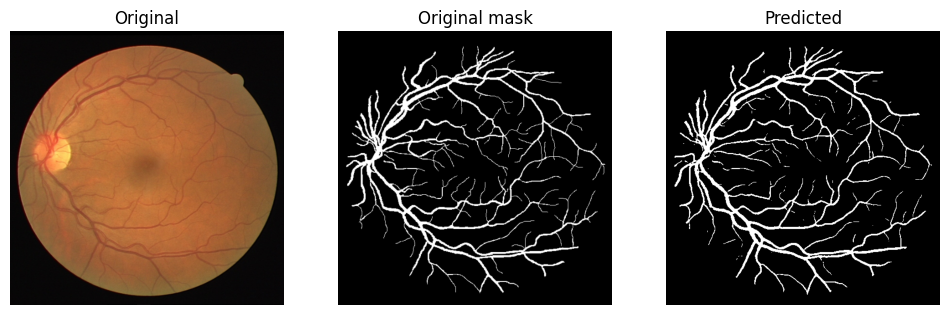

In [73]:
show_result()